# Exercise: Houston Hobby (GHCN Daily PRCP) → Monthly + ENSO (ONI) Merge

**Goal:** Pull daily precipitation for **Houston Hobby** (`USW00012960`) from AWS, convert to **monthly totals (mm)**,
then merge with the **ONI** ENSO index.

You will implement the functions directly in this notebook (self-contained).


## 0) Setup
- Do **not** import from the package; implement inline.
- Use `fsspec` to read remote files.


In [1]:
from __future__ import annotations
from pathlib import Path
from typing import Optional, Sequence, Literal, Dict, Any
import io
import pandas as pd
import fsspec
import numpy as np

def _open_file(path: str | Path):
    with fsspec.open(str(path), mode='rb') as f:
        data = f.read()
    return io.BytesIO(data)

STOR = {"anon": True}


## 1) GHCN Daily for Houston Hobby Airport (USW00012960)
Implement a function to read the **single-station** CSV and convert PRCP from **tenths of mm** to **mm**.

**TODO:**
1. Read `https://noaa-ghcn-pds.s3.amazonaws.com/csv/USW00012960.csv`
2. Convert `DATE` to datetime
3. Convert `VALUE` for `ELEMENT == 'PRCP'` from tenths of mm → mm


In [2]:
GHCN_URL = 's3://noaa-ghcn-pds/csv/by_station/USW00012960.csv'


def load_station_daily(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID','DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    for c in ('TMAX','TMIN','TAVG'):
        if c in wide: wide[c] = wide[c]/10.0
    if 'PRCP' in wide: wide['PRCP'] = wide['PRCP']/10.0
    wide = wide.set_index('DATE')
    return wide

daily = load_station_daily(GHCN_URL)
daily

/var/folders/85/3s7rdbqd1yv9krmrr5_cbw580000gn/T/ipykernel_82540/2801448350.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID':str,'ELEMENT':str}, parse_dates=['DATE'])


ELEMENT,ID,ACMH,ACSH,ADPT,ASLP,ASTP,AWBT,AWND,FMTM,PGTM,...,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT21,WV03
DATE,,,,,,,,,,,,,,,,,,,,,
1969-06-01,USW00012960,50.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1969-06-02,USW00012960,70.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-03,USW00012960,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,1100.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-04,USW00012960,90.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,906.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1969-06-05,USW00012960,50.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,1048.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-02,USW00012960,NaN,NaN,NaN,NaN,NaN,NaN,29.0,NaN,1725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-03,USW00012960,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,1619.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-02-04,USW00012960,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,1705.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2) Resample to monthly sums (mm)
**TODO:**
1. Filter PRCP rows only
2. Set DATE to index and resample to month-start (`'MS'`) **sum**
3. Return a single-column `Series` named `prcp_mm`


In [3]:
def ghcn_prcp_monthly_sum(df: pd.DataFrame) -> pd.Series:
    monthly = df['PRCP'].resample('MS').sum(min_count=1)
    monthly.name = 'prcp_mm'
    return monthly

hou_monthly = ghcn_prcp_monthly_sum(daily).to_frame()
hou_monthly.index.name = 'date'
hou_monthly

,prcp_mm
date,
1969-06-01,38.4
1969-07-01,98.8
1969-08-01,67.9
1969-09-01,154.6
1969-10-01,83.8
...,...
2024-10-01,8.2
2024-11-01,101.7
2024-12-01,92.7


## 3) Read ONI (ENSO) from NOAA PSL
ONI table: `https://psl.noaa.gov/data/correlation/oni.data`

**TODO:** Parse the fixed-width-ish text table into a monthly Series named `oni` with timestamps at month start.


In [4]:
ONI_URL = 'https://psl.noaa.gov/data/correlation/oni.data'

def read_oni_psl(url: str = ONI_URL) -> pd.Series:
    text = fsspec.open(url, 'r').open().read()
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    data = []
    for ln in lines:
        parts = ln.split()
        if not parts or not parts[0].isdigit():
            continue
        year = int(parts[0])
        vals = parts[1:13]
        if len(vals) < 12:
            continue
        for m, v in enumerate(vals, start=1):
            try:
                val = float(v)
            except ValueError:
                continue
            data.append((pd.Timestamp(year=year, month=m, day=1), val))
    s = pd.Series({t: v for t, v in data}).sort_index()
    s.name = 'oni'
    return s

oni = read_oni_psl().to_frame()
oni.index.name = 'date'


## 4) Build monthly precip and merge with ONI
**TODO:**
- Merge on the monthly timestamp using `merge_frames(..., how='left')`


In [6]:
# Merge monthly Houston precip (hou_prcp_mm) with ONI on the 'date' (monthly timestamp), left join as requested.
def merge_frames(df1, df2, how='left'):
    return df1.merge(df2, left_index=True, right_index=True, how=how)


hou_enso = merge_frames(hou_monthly, oni, how='left')

hou_enso.head()


,prcp_mm,oni
date,,
1969-06-01,38.4,0.43
1969-07-01,98.8,0.36
1969-08-01,67.9,0.51
1969-09-01,154.6,0.79
1969-10-01,83.8,0.86


## 5) Visualization
**TODO:**
- Plot monthly precipitation and ONI using monthly values during December, January, and February only.
- Compute correlation coefficient [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html] between `prcp_mm` and `oni` using monthly values during December-February.

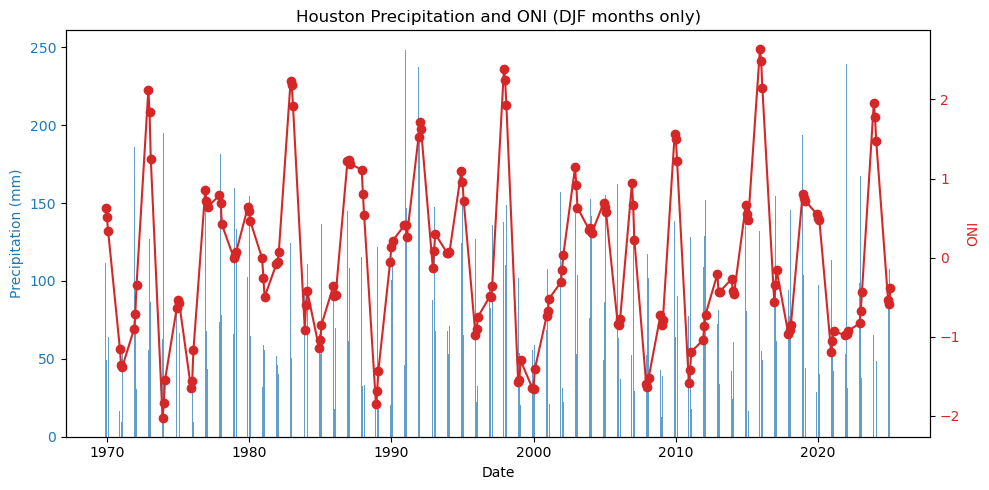

Correlation coefficient between precipitation and ONI (DJF months): 0.25


In [7]:

# Filter for December, January, and February (winter months)
djf = hou_enso[hou_enso.index.month.isin([12, 1, 2])]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Precipitation (mm)', color=color1)
ax1.bar(djf.index, djf['prcp_mm'], width=25, align='center', color=color1, alpha=0.7, label='Precipitation')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('ONI', color=color2)
ax2.plot(djf.index, djf['oni'], marker='o', color=color2, label='ONI')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Houston Precipitation and ONI (DJF months only)")
fig.tight_layout()
plt.show()

# Compute correlation coefficient between prcp_mm and oni for DJF months
corr = djf[['prcp_mm', 'oni']].corr().loc['prcp_mm', 'oni']
print(f"Correlation coefficient between precipitation and ONI (DJF months): {corr:.2f}")


